<a href="https://colab.research.google.com/github/piyengar/vehicle-predictor/blob/master/Vehicle_type_trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Colab specific
- Install additional libraries
- Setup integration with google drive
    - Needs these paths: mount point, Dataset storage path, checkpoint storage path
- Setup content folder as git repo and pull codebase from github
    - This can be done by installing github cli and triggering authentication on browser(TBD)
    - for now we can manually set it up


In [1]:
%%capture
! pip install pytorch-lightning
! pip install pytorch-lightning-bolts
! pip install ipywidgets
! pip install torchmetrics
! pip install efficientnet_pytorch


In [2]:
import os
# Path constants
STORAGE_ROOT='/content/drive'
CARZAM_ROOT= os.path.join(STORAGE_ROOT, 'MyDrive/Gatech/CARZAM')
CHECKPOINT_ROOT=os.path.join(CARZAM_ROOT, 'checkpoints')
PREDICTION_ROOT=os.path.join(CARZAM_ROOT, 'predictions')
DATASET_ROOT=os.path.join(CARZAM_ROOT, 'Datasets')
COMPCAR_ROOT=os.path.join(CARZAM_ROOT, 'CompCars')

In [ ]:
from google.colab import drive
drive.mount(STORAGE_ROOT)
!mkdir -p "{CHECKPOINT_ROOT}"
!mkdir -p "{PREDICTION_ROOT}"
!ln -s "{CHECKPOINT_ROOT}" "checkpoints"
!ln -s "{PREDICTION_ROOT}" "predictions"
!ln -s "{CARZAM_ROOT}" "carzam"


In [2]:

GITHUB_PAT_PATH=os.path.join(STORAGE_ROOT, 'MyDrive/Gatech/github_pat_colab.txt')

with open(GITHUB_PAT_PATH) as reader:
    GITHUB_PAT = reader.readline()


### Setup up codebase from github -- (TBD)

In [3]:
!git init
!git remote add origin "https://{GITHUB_PAT}@github.com/piyengar/vehicle-predictor.git" 
!git pull origin master
!git branch --set-upstream-to=origin/master master

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 229, done.
remote: Counting objects: 100% (229/229), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 229 (delta 129), reused 149 (delta 71), pack-reused 0
Receiving objects: 100% (229/229), 5.54 MiB | 3.16 MiB/s, done.
Resolving deltas: 100% (129/129), done.
From https://github.com/piyengar/vehicle-predictor
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master
Branch 'master' set up to track remote branch 'master' from 'origin'.


### Mount onedrive
Need to configure a remote called 'od' with 'rclone config' before the drive can be mounted.



In [ ]:
!curl https://rclone.org/install.sh | sudo bash
!rclone config

In [ ]:
!mkdir -p od
!rclone --vfs-cache-mode writes mount --daemon od: od/

## Download dataset

In [3]:
import os
import subprocess
from zipfile import ZipFile
from vtype import TypeDatasets

def setup_dataset(dataset: TypeDatasets, carzam_root:str= 'carzam', dest_dir:str = 'dataset'):
    if dataset == TypeDatasets.COMP_CARS:
        os.makedirs(os.path.join(dest_dir, 'CompCars'), exist_ok=True)
        archive_path = os.path.join(carzam_root, 'CompCars', 'sv_data.zip')
        temp_file = os.path.join(dest_dir, 'cc_combined.zip')
        subprocess.run(['zip', '-F', archive_path,  '-b', dest_dir, '--out', temp_file])
        subprocess.run(['unzip', '-P', 'd89551fd190e38', '-d', os.path.join(dest_dir, 'CompCars'), temp_file])
        os.remove(temp_file)
    elif dataset == TypeDatasets.VEHICLE_ID:
        os.makedirs(os.path.join(dest_dir), exist_ok=True)
        archive_path = os.path.join(carzam_root, 'Datasets', 'VehicleID_V1.0.zip')
        subprocess.run(['unzip', '-P', 'CVPR16_IDM@PKU', '-d', dest_dir, archive_path])
        os.rename(os.path.join(dest_dir, "VehicleID_V1.0"), os.path.join(dest_dir, "VehicleID"))
    elif dataset == TypeDatasets.VERI:
        os.makedirs(os.path.join(dest_dir), exist_ok=True)
        archive_path = os.path.join(carzam_root, 'Datasets', 'VeRi_with_plate.zip')
        subprocess.run(['unzip', '-d', dest_dir, archive_path])
    elif dataset == TypeDatasets.CARS196:
        os.makedirs(os.path.join(dest_dir, 'Cars196'), exist_ok=True)
        archive_path = os.path.join(carzam_root, 'Datasets', 'Cars196.zip')
        # print(archive_path)
        # print(" ".join(['unzip', '-d', os.path.join(dest_dir, 'Cars196'), archive_path]))
        subprocess.run(['unzip', '-d', os.path.join(dest_dir, 'Cars196'), archive_path])
    elif dataset == TypeDatasets.BOXCARS116K:
        os.makedirs(os.path.join(dest_dir), exist_ok=True)
        archive_path = os.path.join(carzam_root, 'Datasets', 'BoxCars116k.zip')
        subprocess.run(['unzip', '-d', dest_dir, archive_path])
    elif dataset == TypeDatasets.VRIC:
        os.makedirs(os.path.join(dest_dir, 'VRIC'), exist_ok=True)
        archive_path = os.path.join(carzam_root, 'Datasets', 'VRIC.zip')
        subprocess.run(['unzip', '-d', os.path.join(dest_dir, 'VRIC'), archive_path])

## Setup datasets

### VehicleID Dataset setup

In [ ]:
setup_dataset(TypeDatasets.VEHICLE_ID)

### CompCars Dataset setup

In [22]:
setup_dataset(TypeDatasets.COMP_CARS)

### VeRI dataset Setup

In [11]:
setup_dataset(TypeDatasets.VERI)

### Cars196 dataset Setup

In [16]:
setup_dataset(TypeDatasets.CARS196)

### BoxCars116k dataset Setup

In [6]:
setup_dataset(TypeDatasets.BOXCARS116K)

### VRIC dataset Setup

In [ ]:
setup_dataset(TypeDatasets.VRIC)

## Imports


In [4]:
%load_ext autoreload
%autoreload 2

In [18]:
import pytorch_lightning as pl

from vtype.dataset import (
    BoxCars116kDataset,
    Cars196Dataset,
    CompCarsDataset,
    VehicleIDDataset,
    VeriDataset,
    VRICDataset,
    Type,
)
from vtype import TypeDataModule, TypeDatasets, TypeModel, TypePredictionWriter



## Dataset statistics

In [6]:
# load the dataset
dm = TypeDataModule(TypeDatasets.COMP_CARS)
dm.setup('fit')
train_val_dataloader = dm.train_val_dataset
for ct in train_val_dataloader.get_type_counts():
    print(f'{ct[1].lower()} : {ct[2]}')

sedan : 9736
hatchback : 12415
coupe : 114
suv : 4723
convertible : 34
pickup : 74
minivan : 3746
wagon : 306


## Training

### Training params

In [13]:
# one of : VRIC, Cars196, VehicleID, BoxCars116k, CompCars, Veri, Combined
train_dataset_type = TypeDatasets.CARS196

# Learning rate/eta0
lr=0.02
lr_step=1
lr_step_factor=0.9

batch_size=128
max_epochs=20

model_arch="resnet18"

# development
is_dev_run=False

### Tune Learning Rate

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name           | Type            | Params
---------------------------------------------------
0 | model          | ResNet          | 11.2 M
1 | train_acc      | Accuracy        | 0     
2 | val_confusion  | ConfusionMatrix | 0     
3 | val_acc        | Accuracy        | 0     
4 | val_prec       | Precision       | 0     
5 | val_rec        | Recall          | 0     
6 | val_f1         | F1              | 0     
7 | test_confusion | ConfusionMatrix | 0     
8 | test_acc       | Accuracy        | 0     
---------------------------------------------------
5.1 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until the

RuntimeError: ignored

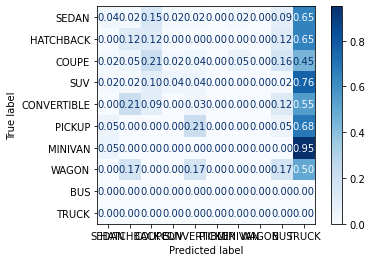

In [20]:
allowed_type_list = [
    t for t in Type
]
# init model
ae = TypeModel(model_arch=model_arch, num_classes=len(allowed_type_list),learning_rate=lr)
# init datamodule
dm = TypeDataModule(dataset_type=train_dataset_type, data_dir="dataset", batch_size=batch_size,
                         allowed_type_list=allowed_type_list)
trainer = pl.Trainer(
    # gpus=-1, 
    max_epochs=20, progress_bar_refresh_rate=20, default_root_dir=CHECKPOINT_ROOT, auto_lr_find=True
    )
lr_finder = trainer.tune(ae,datamodule=dm)['lr_find']
fig = lr_finder.plot(suggest=True)
fig.show()

### SVM

In [ ]:
allowed_color_list = [
                    'black',
                    'white',
                    'red',
                    'yellow',
                    'blue',
                    'gray'
]
model = SGDClassifier(learning_rate='constant', eta0=lr)
# init datamodule
dm = ColorDataModule(
    dataset_name=train_dataset_name, 
    data_dir="dataset", 
    batch_size=batch_size,
    allowed_color_list=allowed_color_list
)
dm.setup('fit')
train_dataloader = dm.train_dataloader()
val_dataloader = dm.val_dataloader()
classes = [i for i in range(len(allowed_color_list))]
now = datetime.now() 
model_checkpoint_path = os.path.join('checkpoints/color', model_arch)
!mkdir -p "{model_checkpoint_path}"
model_checkpoint_file = os.path.join(model_checkpoint_path, f'{train_dataset_name}_{now.strftime("%Y%m%d%H%M%S")}.pkl')
for epoch in range(max_epochs):
    # Train
    stats = {'val_acc':0.0, 'train_acc':0.0}
    batches = tqdm(enumerate(train_dataloader), total=len(train_dataloader), postfix=stats)
    batches.set_description(f'Epoch:{epoch} - Training')
    accs = []
    for mini_batch_idx, (x,_, y) in batches:
        n = len(x)
        x = x.view(n, -1).numpy()
        y = y.numpy()
        model.partial_fit(x, y, classes)
        accs.append(model.score(x, y))
        stats['train_acc'] = np.mean(accs)
        batches.set_postfix(stats)
        if is_dev_run: break
        
    # Validate
    batches = tqdm(enumerate(val_dataloader), total=len(val_dataloader), postfix=stats)
    batches.set_description(f'Epoch:{epoch} - Validating')
    accs = []
    for mini_batch_idx, (x,_, y) in batches:
        n = len(x)
        x = x.view(n, -1).numpy()
        y = y.numpy()
        accs.append(model.score(x, y))
        stats['val_acc'] = np.mean(accs)
        batches.set_postfix(stats)
        if is_dev_run: break
    dump(model, model_checkpoint_file)
    if is_dev_run: break


KeyboardInterrupt: ignored

### Predict using model

In [ ]:
allowed_color_list = [
                    'black',
                    'white',
                    'red',
                    'yellow',
                    'blue',
                    'gray'
]
dataset_names = ['VehicleID', 'CompCars', 'Veri', ]

for idx, train_dataset_name in enumerate([
                        #    'VehicleID', 
                        #    'CompCars', 
                        #    'Veri', 
                           'Combined',
                           ]):
    model_checkpoint_path = os.path.join('checkpoints/color', f'best_{train_dataset_name}_{model_arch}.pkl')
    for dataset_name in dataset_names:
        # TODO need to export to method
        model = load(model_checkpoint_path)

        # init datamodule
        dm = ColorDataModule(
            dataset_name=dataset_name, 
            data_dir="dataset", 
            batch_size=batch_size,
            allowed_color_list=allowed_color_list
        )
        dm.setup('test')
        test_dataloader = dm.test_dataloader()
        # Predict
        batches = tqdm(enumerate(test_dataloader), total=len(test_dataloader), postfix=stats)
        batches.set_description(f'Predicting')
        prediction_root, predict_model_name, best_model_path, prediction_out_file = get_conf_data(train_dataset_name, dataset_name, model_arch)
        prediction_path = os.path.join(prediction_root, prediction_out_file)
        preds = []
        with open(prediction_path, mode="w") as writer:
            writer.truncate()
        for mini_batch_idx, (x, *_) in batches:
            n = len(x)
            x = x.view(n, -1).numpy()
            prediction = model.predict(x)
            with open(prediction_path, mode="a") as writer:
                np.savetxt(writer, prediction, fmt="%d")